In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tables
import sncosmo

from matplotlib.ticker import MultipleLocator, FixedLocator

%matplotlib notebook

In [2]:
# get the light curve data
h5file = tables.open_file("iPTF16hvw.h5", mode="r")
table = h5file.root.photometry

lc = {"P48/CFH12K": dict(), "P60/SEDm": dict()}
for filter_name in ["g", "R"]:
    lc["P48/CFH12K"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'%s') & (mag_err < 10)" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_unc", "f")])
for filter_name in ["u", "g", "r", "i"]:
    lc["P60/SEDm"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P60') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_unc", "f")])
        
ul = {}
ul["g"] = np.array([(row["time"], -2.5*np.log10(3*row["flux_err"]/3631))
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'g') & (time < 57697)")],
                 dtype=[("time", "f"), ("mag_lim", "f")])
ul["R"] = np.array([(row["time"], -2.5*np.log10(3*row["flux_err"]/3631))
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'R') & (time < 57698)")],
                 dtype=[("time", "f"), ("mag_lim", "f")])


### Set some defaults for the plotting colors

In [25]:
T_MAX = 57714.40
t_fl = T_MAX - 17.5 ### Hack for now - needs actual fit
z = 0.03663
Ebv = 0.546-0.413
d_L = 161.3e6 # based on z, H0 = 70, Omega_M = 0.286
mu = 5*np.log10(d_L) - 5
extinction = {"u": 0.638,
              "g": 0.497,
              "r": 0.344,
              "i": 0.256,
              "DESr": 0.327}

colors = {"B": "Blue",
          "V": "#68A225", 
          "g": "LightSeaGreen",
          "R": "Crimson", 
          "r": "Crimson",
          "i": "#FFDB5C"}

markers = {"P48": "o",
           "P60": "h"}
offsets = {"g": 0,
           "R": 2,
           "r": 2,
           "i": 3,
           }

AAMcolors = {'Ni_models': "#2A3132",
             'g': "LightSeaGreen", 
             'B-V': "#5F9683", # ultramarine
             'UVW1-V': "#00CFAA", # cyan
             'U-V': "#FF0038", # fig
             'u-g': "#012161", # royal blue
             'g-r': "#6599FF", # light blue #F77604", # caviar
             'r-i': "#FF0038",  # ripe tomato
             'i-Z': "#AF4425", # cayene
             'Z-Y': "#662225", # red onion 
             'J-H': "#C9A66B" # cinnamon
             } 

AAMoffsets = {'u-g': 0,
              'g-r': 0,
              'r-i': 0,
             }

### Use `sncosmo` to get SALT2 model for 16hvw

In [47]:
# filter data
fp = tables.open_file("filters.h5", mode="r")
filters = dict()
for filter_name in ["g", "r", "i"]:
    filters["P60_" + filter_name] =\
        np.array([(row["wavelength"], row["transmission"])
                  for row in fp.root.P60.SEDm._f_get_child(filter_name)],
                 dtype=[("wavelength", "f"), ("transmission", "f")])
for key in filters:
    band = sncosmo.Bandpass(filters[key]["wavelength"],
                            filters[key]["transmission"],
                            name=key)
    sncosmo.registry.register(band)
fp.close()

# sncosmo model
dust = sncosmo.F99Dust()
host_dust = sncosmo.F99Dust()
model = sncosmo.Model(source="salt2",
                      effects=[host_dust, dust],
                      effect_names=["host", "mw"],
                      effect_frames=["rest", "obs"])
model.set(z=z)
model.set(t0=T_MAX)
model.set(hostebv=0.00)
model.set(mwebv=0.024)
model.set(x0=0.002840)
model.set(x1=-0.152411)
model.set(c=0.098830)

### Use sncosmo to get colors for 2011fe

The Supernova Factory obtained well-calibrated spectra of 2011fe, which can be used to synthesize the colors of the SN at virtually any epoch.

In [67]:
model_11fe = sncosmo.Model(source='snf-2011fe')

# data on 11fe
### UPDATE reddening dict based on NED
t_max_11fe = 5814.98
z_11fe = 0.00080
A_B_11fe = 0.032 # NED
A_V_11fe = 0.024 # NED
A_R_11fe = 0.019
ebv_11fe = A_B_11fe - A_V_11fe
extinction_11fe = {"B": 0.032, "V": 0.024, "R": 0.019,
                   "u": 0.037, 
                   "g": 0.029, 
                   "r": 0.020, 
                   "i": 0.015
                  }

In [8]:
def lc_color(t_blue, m_blue, m_blue_unc, t_red, m_red, m_red_unc, delta_t_merge = 1/24):
    """Return the (merged) color curve for two filters 
    
    Parameters
    ----------
    t_blue : array-like 
        Time array for blue filter measurements
        
    m_blue : array-like, shape = t_blue.shape
        mag array for the blue filter measurements
        
    m_blue_unc : array-like, shape = t_blue.shape
        mag uncertainties array for the blue filter measurements
    
    t_red : array-like
        Time array for red filter measurements
        
    m_red : array-like, shape = t_red.shape
        mag array for the red filter measurements
        
    m_red_unc : array-like, shape = t_red.shape
        mag uncertainties array for the red filter measurements

    delta_t_merge : float, optional (default = 1/24)
    
    Returns
    -------
    t_color : array-like
    
    m_color : array-like
    
    m_color_unc : array-like
    
    """

    if len(t_blue) != len(m_blue) or len(t_blue) != len(m_blue_unc):
        raise ValueError('Length of t_blue, m_blue, and m_blue_unc do not match')

    if len(t_red) != len(m_red) or len(t_red) != len(m_red_unc):
        raise ValueError('Length of t_red, m_red, and m_red_unc do not match')

    t_red = np.ma.array(t_red, mask = np.zeros(t_red.shape))
    m_red = np.ma.array(m_red, mask = np.zeros(m_red.shape))
    m_red_unc = np.ma.array(m_red_unc, mask = np.zeros(m_red_unc.shape))
    
    t_color = np.empty(0)
    m_color = np.empty(0)
    m_color_unc = np.empty(0)
    delta_t_merge = 1/24.
    
    for tb, mb, mbu in zip(t_blue, m_blue, m_blue_unc):
        if np.min(np.abs(t_red - tb)) < delta_t_merge:
            match_idx = np.argmin(np.abs(t_red - tb))
            t_color = np.append(t_color, (tb + t_red[match_idx]) / 2)
            m_color = np.append(m_color, mb - m_red[match_idx] )

            m_color_unc = np.append(m_color_unc, 
                                    np.hypot(mbu, m_red_unc[match_idx]))
            t_red.mask[match_idx] = True
    
    return t_color, m_color, m_color_unc

In [9]:
t_ug, m_ug, m_ug_unc = lc_color(lc["P60/SEDm"]["u"]["time"], 
                                lc["P60/SEDm"]["u"]["mag"], 
                                lc["P60/SEDm"]["u"]["mag_unc"], 
                                lc["P60/SEDm"]["g"]["time"], 
                                lc["P60/SEDm"]["g"]["mag"], 
                                lc["P60/SEDm"]["g"]["mag_unc"])
t_gr, m_gr, m_gr_unc = lc_color(lc["P60/SEDm"]["g"]["time"], 
                                lc["P60/SEDm"]["g"]["mag"], 
                                lc["P60/SEDm"]["g"]["mag_unc"], 
                                lc["P60/SEDm"]["r"]["time"], 
                                lc["P60/SEDm"]["r"]["mag"], 
                                lc["P60/SEDm"]["r"]["mag_unc"])
t_ri, m_ri, m_ri_unc = lc_color(lc["P60/SEDm"]["r"]["time"], 
                                lc["P60/SEDm"]["r"]["mag"], 
                                lc["P60/SEDm"]["r"]["mag_unc"], 
                                lc["P60/SEDm"]["i"]["time"], 
                                lc["P60/SEDm"]["i"]["mag"], 
                                lc["P60/SEDm"]["i"]["mag_unc"])

<IPython.core.display.Javascript object>


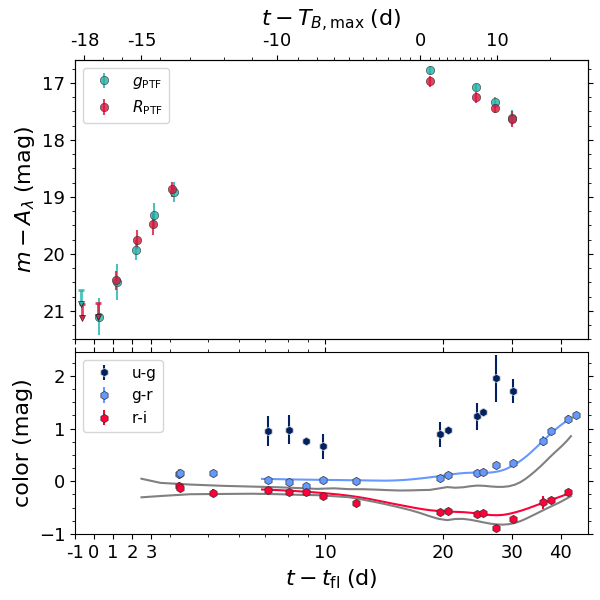

In [73]:
# fig, ax = plt.subplots(figsize = (6,3.5))

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(hspace=0.001)
ax = plt.subplot2grid([5, 1], [0, 0], rowspan=3)
colax = plt.subplot2grid([5, 1], [3, 0], rowspan=2)

ax.errorbar((lc["P48/CFH12K"]["g"]["time"] - t_fl)/(1+z), 
            lc["P48/CFH12K"]["g"]["mag"] - extinction["g"], 
            lc["P48/CFH12K"]["g"]["mag_unc"],
            fmt=markers["P48"], color=colors["g"], 
            mec="0.2", mew=0.5, alpha=0.8,
            label="$g_\mathrm{PTF}$")
ax.errorbar((lc["P48/CFH12K"]["R"]["time"] - t_fl)/(1+z), 
            lc["P48/CFH12K"]["R"]["mag"] - extinction["DESr"], 
            lc["P48/CFH12K"]["R"]["mag_unc"],
            fmt=markers["P48"], color=colors["R"],
            mec="0.2", mew=0.5, alpha=0.8,
            label="$R_\mathrm{PTF}$")

# add upper limits
ULoffset = 0.25
yerr_g = np.zeros((2, len(ul['g'])))
yerr_g[0,:] += ULoffset
yerr_R = np.zeros((2, len(ul['R'])))
yerr_R[0,:] += ULoffset

ax.errorbar((ul['g']['time'] - t_fl)/(1+z), 
            ul['g']['mag_lim']+ULoffset - extinction["g"], yerr = yerr_g, 
            fmt = 'v', color = colors["g"], ms = 5, alpha=0.8,
            elinewidth=2, capsize = 0, mec = 'k', mew = 0.5)
ax.plot((ul['g']['time'] - t_fl)/(1+z),ul['g']['mag_lim'] - extinction["g"], '_', 
        color = colors["g"], mew = 2, ms = 5, alpha=0.8)
ax.errorbar((ul['R']['time'] - t_fl)/(1+z), ul['R']['mag_lim']+ULoffset - extinction["DESr"], yerr = yerr_R, 
            fmt = 'v', color = colors["R"], ms = 5, alpha=0.8,
            elinewidth=2, capsize = 0, mec = 'k', mew = 0.5)
ax.plot((ul['R']['time'] - t_fl)/(1+z),ul['R']['mag_lim'] - extinction["DESr"], '_', 
        color = colors["R"], mew = 2, ms = 5, alpha=0.8)

ax.set_ylabel("$m - A_\lambda \; (\mathrm{mag})$", fontsize=16)
ax.set_ylim(21.5, 16.6)
ax.tick_params(axis='both', which='both', top=True, right=True, labelsize=13)
ax.legend(loc=2, fontsize=11)

ax.yaxis.set_minor_locator(MultipleLocator(0.25))

colax.errorbar((t_ug - t_fl)/(1+z), m_ug - (extinction["u"] - extinction["g"]), m_ug_unc, 
               fmt=markers["P60"], color=AAMcolors["u-g"], 
               mec = "0.8", mew=0.5, label="u-g")
colax.errorbar((t_gr - t_fl)/(1+z), m_gr - (extinction["g"] - extinction["r"]), m_gr_unc, 
               fmt=markers["P60"], color=AAMcolors["g-r"],
               mec = "0.2", mew=0.5, label="g-r")
colax.errorbar((t_ri - t_fl)/(1+z), m_ri - (extinction["r"] - extinction["i"]), m_ri_unc, 
               fmt=markers["P60"], color=AAMcolors["r-i"], 
               mec = "0.2", mew=0.5, label="r-i")

t = np.linspace(T_MAX-10*(1+z), T_MAX+25*(1+z), 300)
colax.plot((t - t_fl)/(1+z), 
        model.color("P60_g", "P60_r", "ab", t), 
        linestyle='-', 
        color=AAMcolors["g-r"])
colax.plot((t - t_fl)/(1+z), 
        model.color("P60_r", "P60_i", "ab", t), 
        linestyle='-', 
        color=AAMcolors["r-i"])

# 2011fe colors
times_11fe = np.linspace(-15,25,41)
colax.plot(times_11fe + (T_MAX - t_fl), 
         (model_11fe.color("sdssg", "sdssr", "ab", times_11fe*(1+z_11fe)) - 
         (extinction_11fe["g"] - extinction_11fe["r"])),
         color="0.5")
colax.plot(times_11fe + (T_MAX - t_fl), 
         (model_11fe.color("sdssr", "sdssi", "ab", times_11fe*(1+z_11fe)) - 
         (extinction_11fe["r"] - extinction_11fe["i"])),
         color="0.5")

colax.set_ylabel("color (mag)", fontsize=16)
colax.set_xlabel("$t - t_\mathrm{fl} \; (\mathrm{d})$", fontsize=16)
colax.set_ylim(-1, 2.45)
colax.tick_params(axis='both', which='both', top=True, right=True, labelsize=13)
colax.legend(loc=2,fontsize=11)
    
# set up time relative to T_Bmax
ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 16)
for axis in [ax, colax, ax2]:
    axis.set_xscale("symlog", linthreshx=4, linscalex = 0.175, subsx = [2,3,4,5,6,7,8,9])

for axis in [ax, colax]:
#     axis.xaxis.set_major_locator(MultipleLocator(10))
#     axis.xaxis.set_minor_locator(MultipleLocator(2))
    axis.yaxis.set_minor_locator(MultipleLocator(0.25))
    axis.set_xlim(-1,47)
    axis.set_xticks([-1, 0, 1, 2, 3, 10, 20, 30, 40])
colax.set_xticklabels([-1, 0, 1, 2, 3, 10, 20, 30, 40])
ax.set_xticklabels([])

ax2.set_xlim(ax.get_xlim())
bmax_ticks = [-18, -15, -10, 0, 10]
ax2.set_xticks(np.array(bmax_ticks) + (T_MAX - t_fl))
ax2.set_xticklabels(bmax_ticks, fontsize = 13)
ax2.xaxis.set_minor_locator(FixedLocator(np.append(np.linspace(-19, 10, 30), np.linspace(20, 100, 9)) + (T_MAX - t_fl)))

fig.subplots_adjust(top=0.9, right=0.98, hspace=0.15)
# fig.savefig("./plots/16hvw_lc.pdf")

In [72]:
model.color("P60_i", "sdssi", "ab", t)

array([ 0.0529387 ,  0.05231026,  0.05169788,  0.05110043,  0.05051687,
        0.04994627,  0.04938781,  0.04884069,  0.04830423,  0.04777623,
        0.04724739,  0.04672126,  0.04620324,  0.04569811,  0.04521009,
        0.04474291,  0.04429986,  0.04388387,  0.04348923,  0.04310638,
        0.04273686,  0.0423821 ,  0.0420434 ,  0.04172195,  0.04141882,
        0.04113503,  0.04087104,  0.04062235,  0.0403873 ,  0.04016556,
        0.03995681,  0.03976076,  0.03957715,  0.03940575,  0.03924636,
        0.03909814,  0.03895984,  0.03883146,  0.03871303,  0.03860461,
        0.03850627,  0.03841807,  0.03834013,  0.0382727 ,  0.03821789,
        0.03817491,  0.0381419 ,  0.03811707,  0.03809867,  0.03808498,
        0.03807432,  0.03806499,  0.03805913,  0.03806373,  0.03807591,
        0.03809238,  0.03810981,  0.03812491,  0.03813433,  0.03813476,
        0.03812305,  0.03810341,  0.03807858,  0.03804833,  0.03801243,
        0.03797063,  0.03792269,  0.03786836,  0.0378074 ,  0.03

<IPython.core.display.Javascript object>


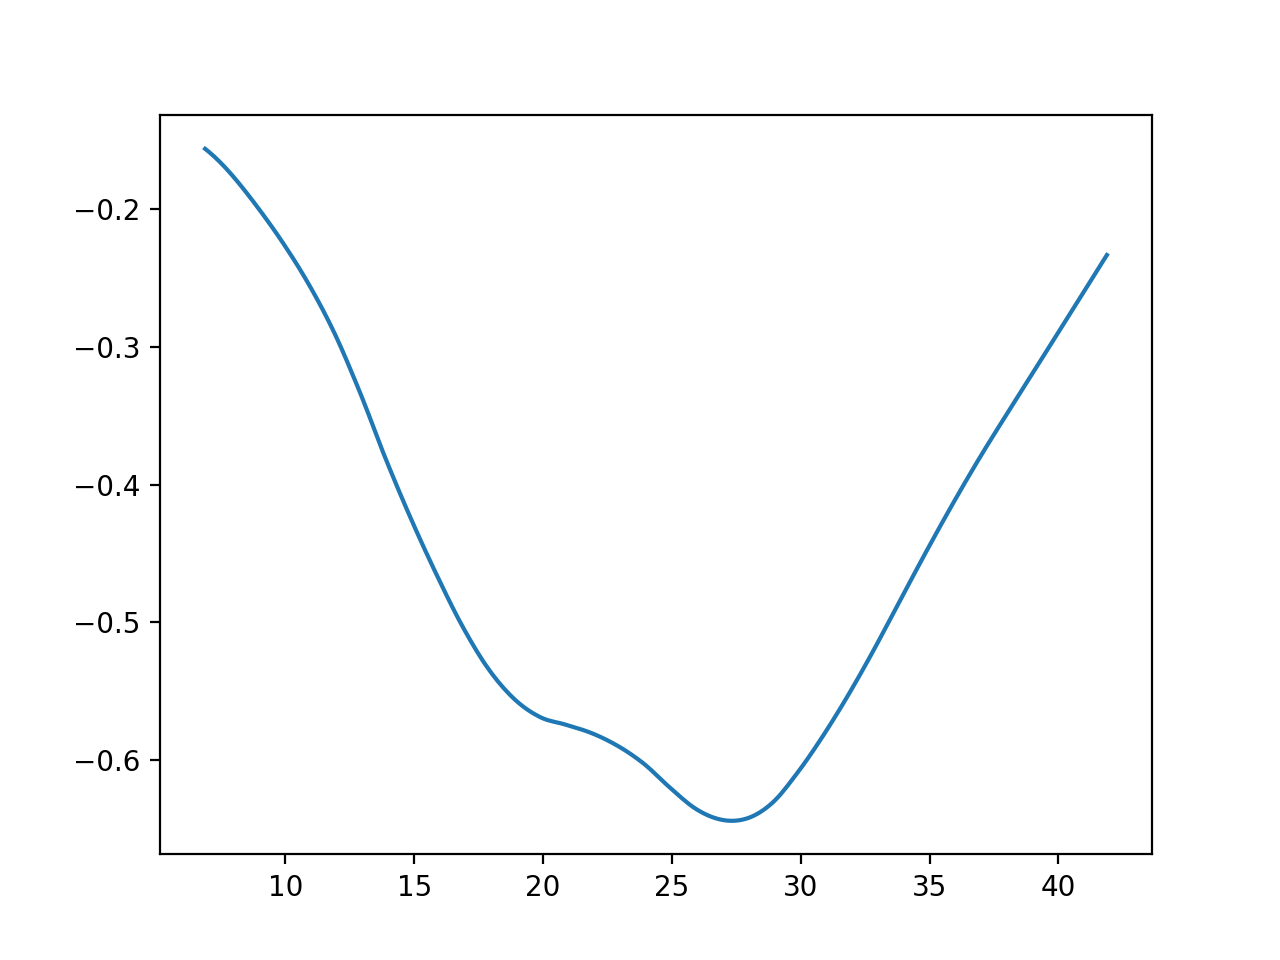

In [54]:
plt.figure()
plt.plot((t - t_fl)/(1+z), 
        model.color("P60_r", "P60_i", "ab", t)
        )

In [55]:
t_fl

57696.9

In [56]:
T_MAX

57714.4